In [1]:
import sys
sys.path.append("../")

from generate_parameter_sample import PARAMETER_RANGES
from utils import *
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import pickle
import os
from scipy.stats import gaussian_kde, pearsonr
from experiment import unpack_and_dequantize

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

# Compute Metrics

In [2]:
for D in ["cpt", "pt", "eut"]:
    mean = []
    gini = []
    sen = []
    for f in tqdm(os.listdir("../" + D)):
        with open(os.path.join("../" + D, f), "rb") as f:
            res = pickle.load(f)
        wealth = unpack_and_dequantize(res["wealth"][:,-1], 200)
        health = unpack_and_dequantize(res["health"][:,-1], 200)
        util = utility(wealth, health, alpha=res['params']['alpha'])
        m = mean_util(util)
        g = gini_coeff(util)
        s = m * (1-g)
        mean.append(m)
        gini.append(g)
        sen.append(s)
    with open(f"../{D}_sen_welfare", "wb") as f:
        pickle.dump(sen, f)
    with open(f"../{D}_gini", "wb") as f:
        pickle.dump(gini, f)
    with open(f"../{D}_mean_util", "wb") as f:
        pickle.dump(mean, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

# CPT

In [8]:
directory = "../cpt"
with open(f"{directory}_sen_welfare", "rb") as f:
    sen = pickle.load(f)
data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["rate"], P["A"], P["lambda"], P["gamma"], sen[idx]))
    data.append(elem)

0it [00:00, ?it/s]

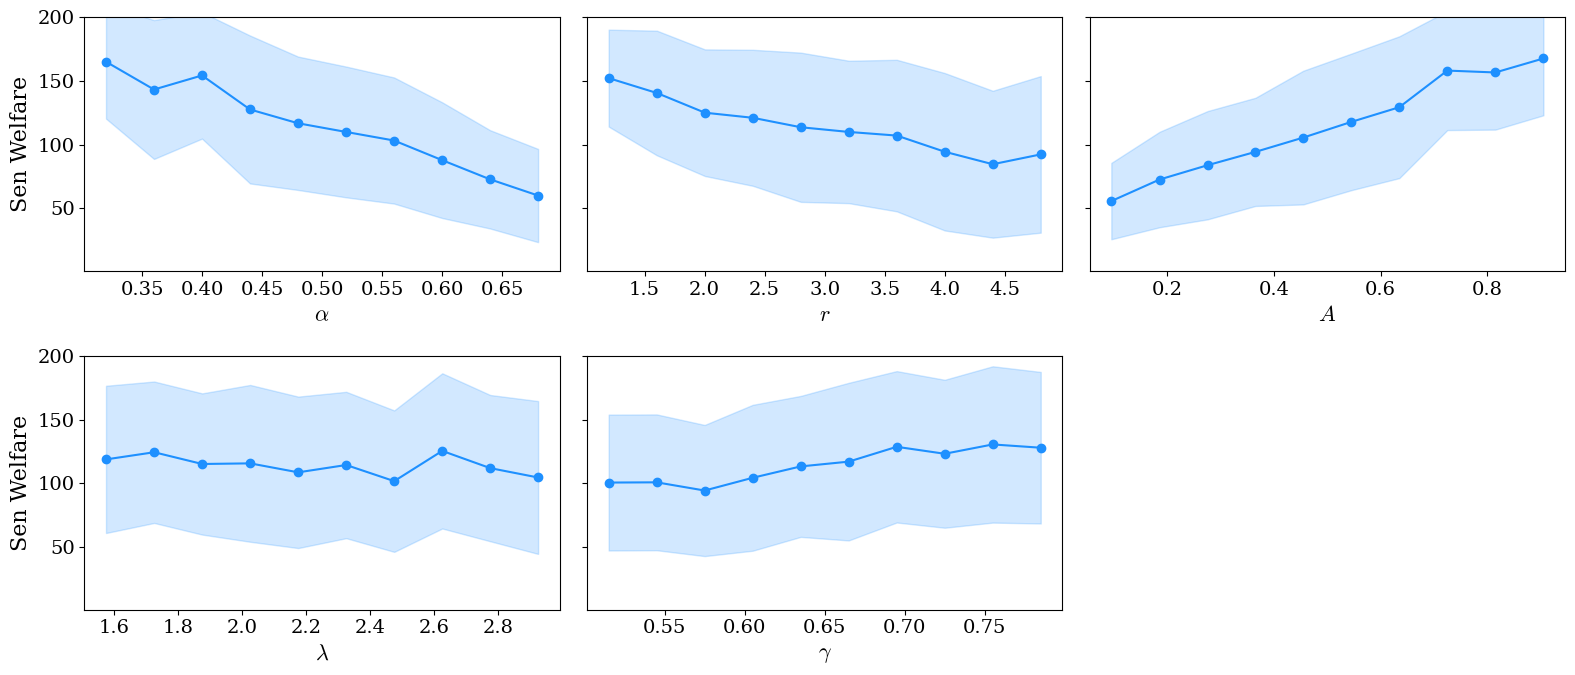

In [9]:
cols = ["alpha", "rate", "A", "lambda", "gamma", "welfare"]
df = pd.DataFrame(data, columns=cols)

nbins = 10
labels = [r"$\alpha$", r"$r$", r"$A$", r"$\lambda$", r"$\gamma$"]
fig, axs = plt.subplots(2, 3, figsize=(16,7), sharey=True)
for i,param in enumerate(cols[:-1]):
    df["bin"] = pd.cut(df[param], bins=nbins)
    group = df.groupby("bin")["welfare"]
    mean_vals = group.mean()
    std_vals = group.std()
    bin_centers = [interval.mid for interval in mean_vals.index]
    axs[int(i/3)][i%3].plot(bin_centers, mean_vals.values, label="Mean Sen Welfare", color="dodgerblue", marker='o')
    axs[int(i/3)][i%3].fill_between(bin_centers,
                    mean_vals - std_vals,
                    mean_vals + std_vals,
                    alpha=0.2,
                    label="± 1 std",
                    color="dodgerblue"
    )
    axs[int(i/3)][i%3].set_xlabel(labels[i])
    axs[int(i/3)][i%3].set_ylim(1,200)

axs[0][0].set_ylabel("Sen Welfare")
axs[1][0].set_ylabel("Sen Welfare")
axs[1][2].set_visible(False)
fig.tight_layout()
plt.savefig("../figures/cpt_sen_welfare.pdf", bbox_inches="tight")
plt.show()

# PT

In [10]:
directory = "pt"
with open(f"../{directory}_sen_welfare", "rb") as f:
    sen = pickle.load(f)
data = []
for idx,f in tqdm(enumerate(os.listdir("../"+directory))):
    with open(os.path.join("../"+directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["rate"], P["A"], P["lambda"], sen[idx]))
    data.append(elem)

0it [00:00, ?it/s]

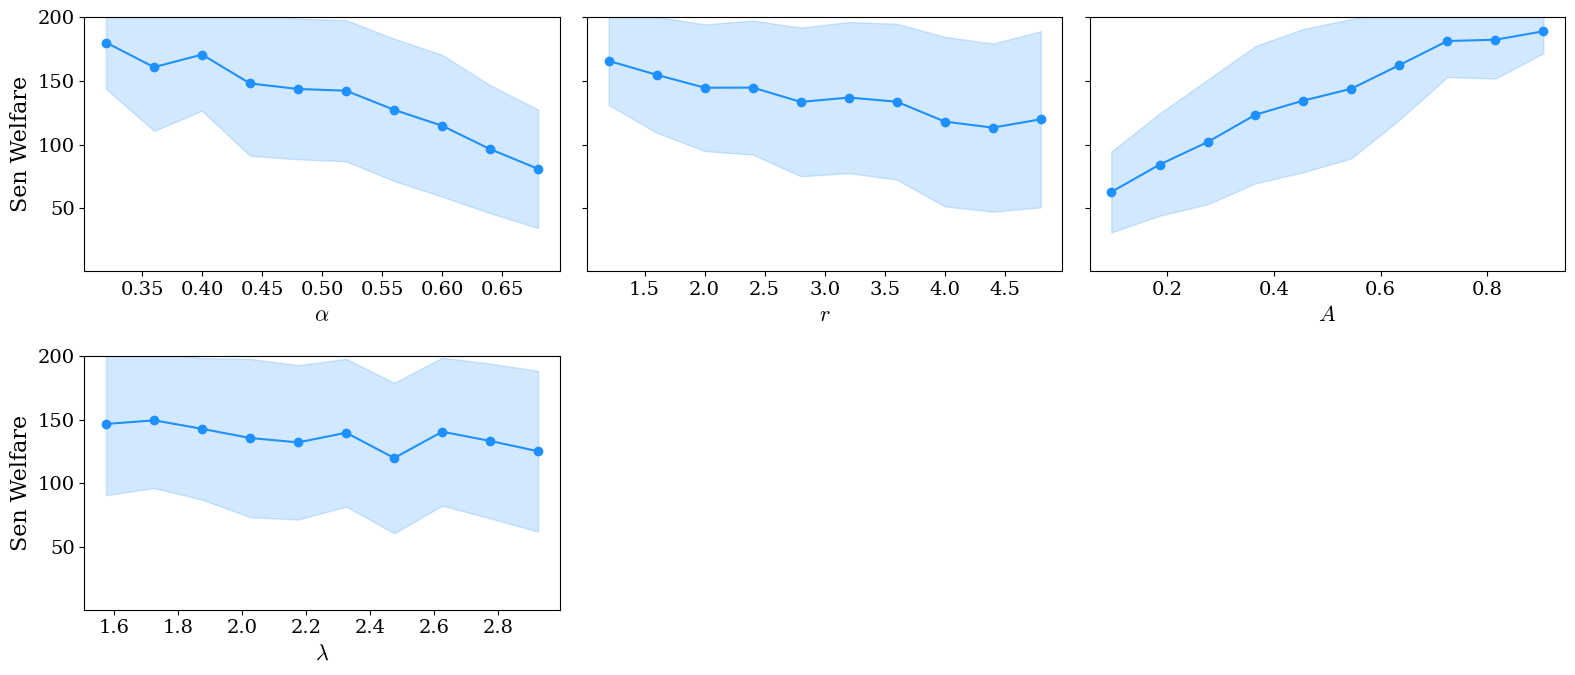

In [11]:
cols = ["alpha", "rate", "A", "lambda", "welfare"]
df = pd.DataFrame(data, columns=cols)

nbins = 10
labels = [r"$\alpha$", r"$r$", r"$A$", r"$\lambda$"]
fig, axs = plt.subplots(2, 3, figsize=(16,7), sharey=True)
for i,param in enumerate(cols[:-1]):
    df["bin"] = pd.cut(df[param], bins=nbins)
    group = df.groupby("bin")["welfare"]
    mean_vals = group.mean()
    std_vals = group.std()
    bin_centers = [interval.mid for interval in mean_vals.index]
    axs[int(i/3)][i%3].plot(bin_centers, mean_vals.values, label="Mean Sen Welfare", color="dodgerblue", marker="o")
    axs[int(i/3)][i%3].fill_between(bin_centers,
                    mean_vals - std_vals,
                    mean_vals + std_vals,
                    alpha=0.2,
                    label="± 1 std",
                    color="dodgerblue"
    )
    axs[int(i/3)][i%3].set_xlabel(labels[i])
    axs[int(i/3)][i%3].set_ylim(1,200)

axs[0][0].set_ylabel("Sen Welfare")
axs[1][0].set_ylabel("Sen Welfare")
axs[1][2].set_visible(False)
axs[1][1].set_visible(False)

fig.tight_layout()
plt.savefig(f"../figures/{directory}_sen_welfare.pdf", bbox_inches="tight")
plt.show()

# EUT

In [12]:
directory = "eut"
with open(f"../{directory}_sen_welfare", "rb") as f:
    sen = pickle.load(f)
data = []
for idx,f in tqdm(enumerate(os.listdir("../"+directory))):
    with open(os.path.join("../"+directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["rate"], P["A"], sen[idx]))
    data.append(elem)

0it [00:00, ?it/s]

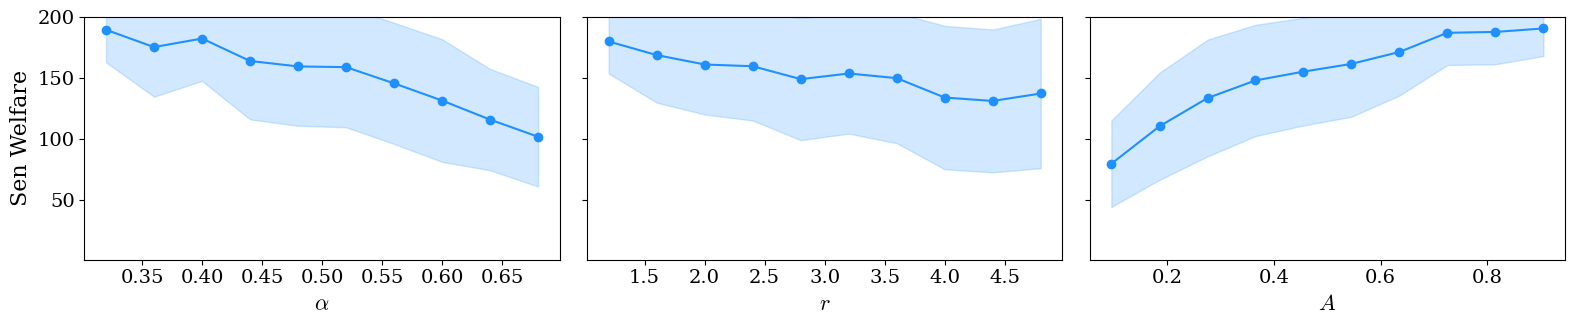

In [13]:
cols = ["alpha", "rate", "A", "welfare"]
df = pd.DataFrame(data, columns=cols)

nbins = 10
labels = [r"$\alpha$", r"$r$", r"$A$", r"$s$"]
fig, axs = plt.subplots(1, 3, figsize=(16,3.5), sharey=True)
for i,param in enumerate(cols[:-1]):
    df["bin"] = pd.cut(df[param], bins=nbins)
    group = df.groupby("bin")["welfare"]
    mean_vals = group.mean()
    std_vals = group.std()
    bin_centers = [interval.mid for interval in mean_vals.index]
    axs[i].plot(bin_centers, mean_vals.values, label="Mean Sen Welfare", color="dodgerblue", marker='o')
    axs[i].fill_between(bin_centers,
                    mean_vals - std_vals,
                    mean_vals + std_vals,
                    alpha=0.2,
                    label="± 1 std",
                    color="dodgerblue"
    )
    axs[i].set_xlabel(labels[i])
    axs[i].set_ylim(1,200)

axs[0].set_ylabel("Sen Welfare")
fig.tight_layout()
plt.savefig(f"../figures/{directory}_sen_welfare.pdf", bbox_inches="tight")
plt.show()

# KDEs

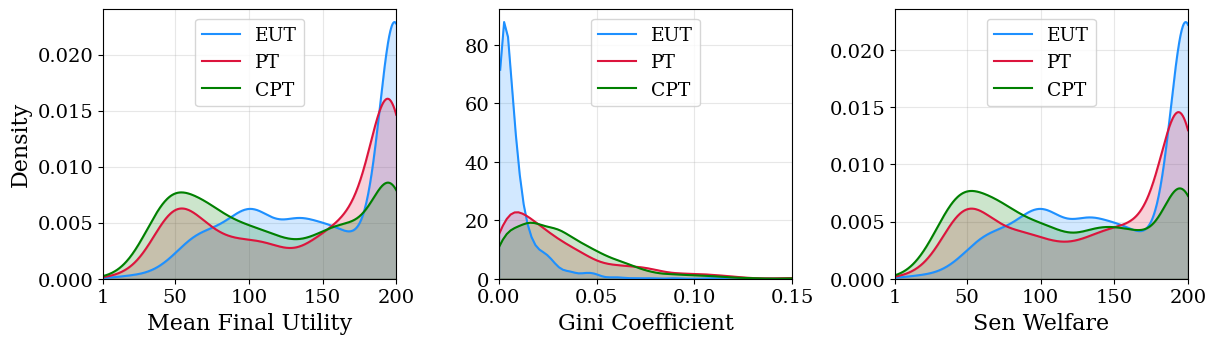

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(14,3.5))
labels = ["EUT", "PT", "CPT"]
colors = ["dodgerblue", "crimson", "green"]

# Mean Final Utility
for i, directory in enumerate(["../eut", "../pt", "../cpt"]):
    with open(f"{directory}_mean_util", "rb") as f:
        M = pickle.load(f)
    kde = gaussian_kde(M, bw_method=0.2)
    x_vals = np.linspace(1, 200, 500)
    y_vals = kde(x_vals)
    y_vals /= np.trapz(y_vals, x_vals)
    axs[0].plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=1.5)
    axs[0].fill_between(x_vals, y_vals, color=colors[i], alpha=0.2)
axs[0].set_ylabel("Density")
axs[0].set_xlabel("Mean Final Utility")
axs[0].legend(loc="upper center")
axs[0].set_ylim(0,)
axs[0].set_xticks([1, 50, 100, 150, 200])
axs[0].grid()
axs[0].set_xlim(1,200)

# Gini Coefficient
for i, directory in enumerate(["../eut", "../pt", "../cpt"]):
    with open(f"{directory}_gini", "rb") as f:
        G = pickle.load(f)
    kde = gaussian_kde(G, bw_method=0.2)
    x_vals = np.linspace(min(G), 1, 500)
    y_vals = kde(x_vals)
    y_vals /= np.trapz(y_vals, x_vals)
    axs[1].plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=1.5)
    axs[1].fill_between(x_vals, y_vals, color=colors[i], alpha=0.2)
axs[1].set_xlabel("Gini Coefficient")
axs[1].legend(loc="upper center")
axs[1].set_xlim(0, 0.15)
axs[1].grid()
axs[1].set_ylim(0,)

# Sen Welfare
for i, directory in enumerate(["../eut", "../pt", "../cpt"]):
    with open(f"{directory}_sen_welfare", "rb") as f:
        sen = pickle.load(f)
    kde = gaussian_kde(sen, bw_method=0.2)
    x_vals = np.linspace(1, 200, 500)
    y_vals = kde(x_vals)
    y_vals /= np.trapz(y_vals, x_vals)
    axs[2].plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=1.5)
    axs[2].fill_between(x_vals, y_vals, color=colors[i], alpha=0.2)
axs[2].set_xlabel("Sen Welfare")
axs[2].set_xticks([1, 50, 100, 150, 200])
axs[2].legend(loc="upper center")
axs[2].grid()
axs[2].set_ylim(0,)
axs[2].set_xlim(1,200)

fig.subplots_adjust(wspace=0.35)
plt.savefig("../figures/util_gini_welfare_kde_comparison.pdf", bbox_inches="tight")
plt.show()

# Pairwise EUT vs. PT vs. CPT Comparison

In [4]:
directory = "../eut"
with open(f"{directory}_sen_welfare", "rb") as f:
    eut_sen = pickle.load(f)

eut_data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = (P["alpha"], P["rate"], 1, P["A"], 1)
    eut_data.append(elem)

0it [00:00, ?it/s]

In [5]:
directory = "../cpt"
with open(f"{directory}_sen_welfare", "rb") as f:
    cpt_sen = pickle.load(f)
    
cpt_data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = (P["alpha"], P["rate"], P["lambda"], P["A"], P["gamma"])
    cpt_data.append(elem)

0it [00:00, ?it/s]

In [6]:
directory = "../pt"
with open(f"{directory}_sen_welfare", "rb") as f:
    pt_sen = pickle.load(f)

pt_data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = (P["alpha"], P["rate"], P["lambda"], P["A"], P["gamma"])
    pt_data.append(elem)

0it [00:00, ?it/s]

In [14]:
cpt_data, cpt_sen = zip(*sorted(zip(cpt_data, cpt_sen)))
pt_data, pt_sen = zip(*sorted(zip(pt_data, pt_sen)))
eut_data, eut_sen = zip(*sorted(zip(eut_data, eut_sen)))

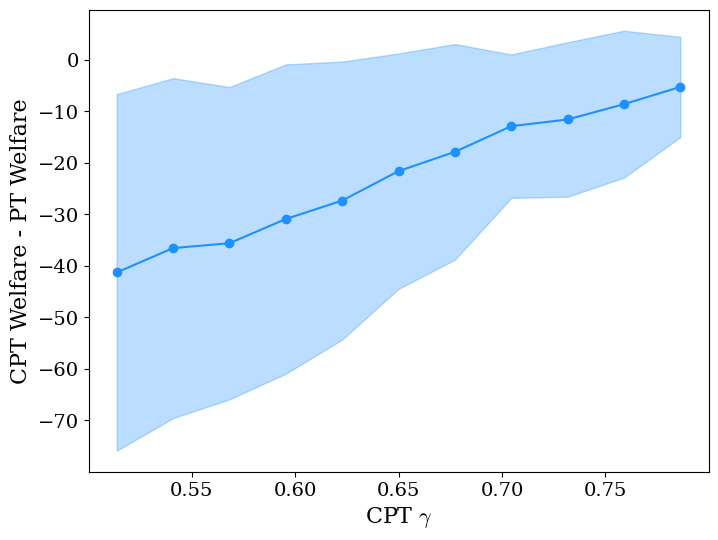

PearsonRResult(statistic=np.float64(0.43315664969280687), pvalue=np.float64(4.408893650789461e-48))

In [77]:
cpt_gamma = [cpt_data[i][-1] for i in range(len(cpt_data))]
cpt_pt_sen = [cpt_sen[i] - pt_sen[i] for i in range(len(pt_sen))]

N = 11

cpt_gamma = np.array(cpt_gamma)
cpt_pt_sen = np.array(cpt_pt_sen)

bins = np.linspace(cpt_gamma.min(), cpt_gamma.max(), N+1)
bin_centers = []
means = []
stds = []
for i in range(N):
    left, right = bins[i], bins[i+1]
    mask = (cpt_gamma >= left) & (cpt_gamma < right)
    if np.any(mask):
        bin_centers.append((left + right) / 2)
        means.append(np.mean(cpt_pt_sen[mask]))
        stds.append(np.std(cpt_pt_sen[mask]))
    else:
        bin_centers.append((left + right) / 2)
        means.append(np.nan)
        stds.append(np.nan)
bin_centers = np.array(bin_centers)
means = np.array(means)
stds = np.array(stds)

plt.plot(bin_centers, means, color="dodgerblue", marker="o")
plt.fill_between(bin_centers, means - stds, means + stds, alpha=0.3, color="dodgerblue")
plt.xlabel(r"CPT $\gamma$")
plt.ylabel("CPT Welfare - PT Welfare")
plt.show()
pearsonr(cpt_gamma, cpt_pt_sen)

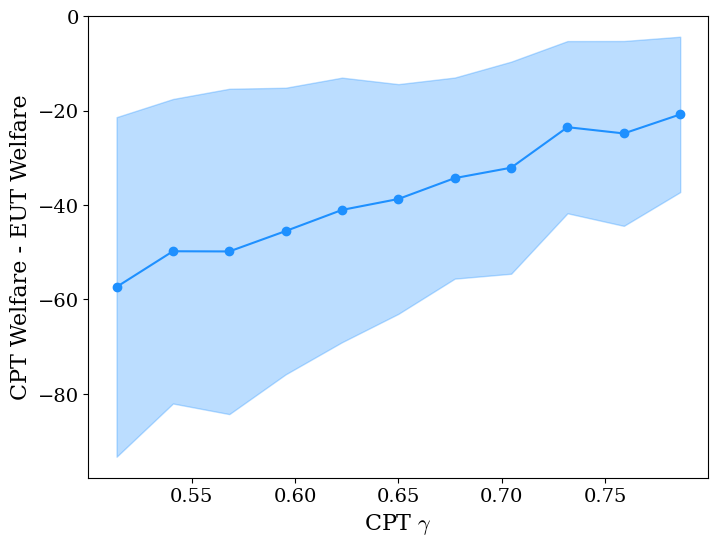

PearsonRResult(statistic=np.float64(0.39341881602856127), pvalue=np.float64(3.033517437902158e-39))

In [78]:
cpt_gamma = [cpt_data[i][-1] for i in range(len(cpt_data))]
cpt_eut_sen = [cpt_sen[i] - eut_sen[i] for i in range(len(pt_sen))]

N = 11
cpt_gamma = np.array(cpt_gamma)
cpt_eut_sen = np.array(cpt_eut_sen)

bins = np.linspace(cpt_gamma.min(), cpt_gamma.max(), N+1)
bin_centers = []
means = []
stds = []
for i in range(N):
    left, right = bins[i], bins[i+1]
    mask = (cpt_gamma >= left) & (cpt_gamma < right)
    if np.any(mask):
        bin_centers.append((left + right) / 2)
        means.append(np.mean(cpt_eut_sen[mask]))
        stds.append(np.std(cpt_eut_sen[mask]))
    else:
        bin_centers.append((left + right) / 2)
        means.append(np.nan)
        stds.append(np.nan)
bin_centers = np.array(bin_centers)
means = np.array(means)
stds = np.array(stds)

plt.plot(bin_centers, means, color="dodgerblue", marker="o")
plt.fill_between(bin_centers, means - stds, means + stds, alpha=0.3, color="dodgerblue")
plt.xlabel(r"CPT $\gamma$")
plt.ylabel("CPT Welfare - EUT Welfare")
plt.show()
pearsonr(cpt_gamma, cpt_eut_sen)

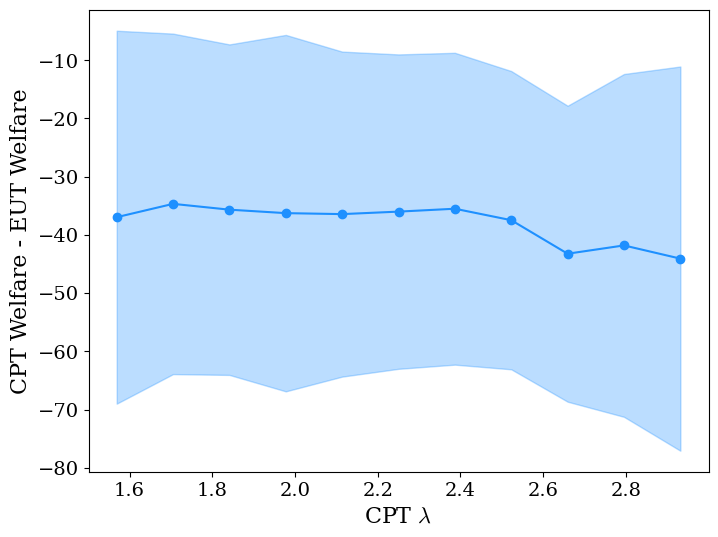

PearsonRResult(statistic=np.float64(-0.0914269794354345), pvalue=np.float64(0.003409036527213637))

In [79]:
cpt_lambda = [cpt_data[i][2] for i in range(len(cpt_data))]
cpt_eut_sen = [cpt_sen[i] - eut_sen[i] for i in range(len(pt_sen))]

N = 11
cpt_lambda = np.array(cpt_lambda)
cpt_eut_sen = np.array(cpt_eut_sen)

bins = np.linspace(cpt_lambda.min(), cpt_lambda.max(), N+1)
bin_centers = []
means = []
stds = []
for i in range(N):
    left, right = bins[i], bins[i+1]
    mask = (cpt_lambda >= left) & (cpt_lambda < right)
    if np.any(mask):
        bin_centers.append((left + right) / 2)
        means.append(np.mean(cpt_eut_sen[mask]))
        stds.append(np.std(cpt_eut_sen[mask]))
    else:
        bin_centers.append((left + right) / 2)
        means.append(np.nan)
        stds.append(np.nan)
bin_centers = np.array(bin_centers)
means = np.array(means)
stds = np.array(stds)

plt.plot(bin_centers, means, color="dodgerblue", marker="o")
plt.fill_between(bin_centers, means - stds, means + stds, alpha=0.3, color="dodgerblue")
plt.xlabel(r"CPT $\lambda$")
plt.ylabel("CPT Welfare - EUT Welfare")
plt.show()
pearsonr(cpt_lambda, cpt_eut_sen)

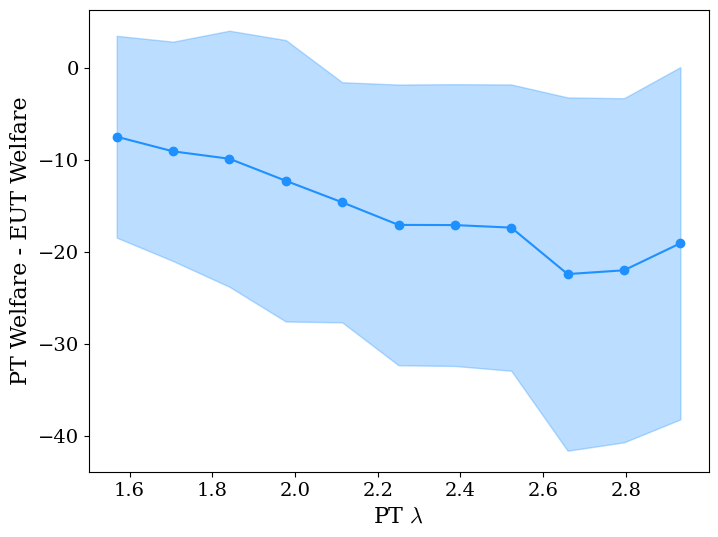

PearsonRResult(statistic=np.float64(-0.2809725219540107), pvalue=np.float64(4.936494895685065e-20))

In [80]:
pt_lambda = [pt_data[i][2] for i in range(len(pt_data))]
pt_eut_sen = [pt_sen[i] - eut_sen[i] for i in range(len(pt_sen))]

N = 11
pt_lambda = np.array(pt_lambda)
pt_eut_sen = np.array(pt_eut_sen)

bins = np.linspace(pt_lambda.min(), pt_lambda.max(), N+1)
bin_centers = []
means = []
stds = []
for i in range(N):
    left, right = bins[i], bins[i+1]
    mask = (pt_lambda >= left) & (pt_lambda < right)
    if np.any(mask):
        bin_centers.append((left + right) / 2)
        means.append(np.mean(pt_eut_sen[mask]))
        stds.append(np.std(pt_eut_sen[mask]))
    else:
        bin_centers.append((left + right) / 2)
        means.append(np.nan)
        stds.append(np.nan)
bin_centers = np.array(bin_centers)
means = np.array(means)
stds = np.array(stds)

plt.plot(bin_centers, means, color="dodgerblue", marker="o")
plt.fill_between(bin_centers, means - stds, means + stds, alpha=0.3, color="dodgerblue")
plt.xlabel(r"PT $\lambda$")
plt.ylabel("PT Welfare - EUT Welfare")
plt.show()
pearsonr(pt_lambda, pt_eut_sen)

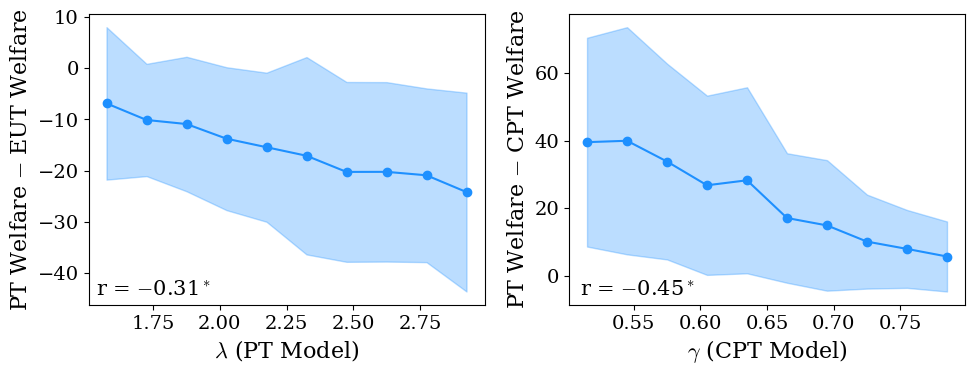

In [18]:
N = 10
fig, axs = plt.subplots(1, 2, figsize=(10,4))


pt_lambda = [pt_data[i][2] for i in range(len(pt_data))]
pt_eut_sen = [pt_sen[i] - eut_sen[i] for i in range(len(pt_sen))]
pt_lambda = np.array(pt_lambda)
pt_eut_sen = np.array(pt_eut_sen)
bins = np.linspace(pt_lambda.min(), pt_lambda.max(), N+1)
bin_centers = []
means = []
stds = []
for i in range(N):
    left, right = bins[i], bins[i+1]
    mask = (pt_lambda >= left) & (pt_lambda < right)
    if np.any(mask):
        bin_centers.append((left + right) / 2)
        means.append(np.mean(pt_eut_sen[mask]))
        stds.append(np.std(pt_eut_sen[mask]))
    else:
        bin_centers.append((left + right) / 2)
        means.append(np.nan)
        stds.append(np.nan)
bin_centers = np.array(bin_centers)
means = np.array(means)
stds = np.array(stds)
axs[0].plot(bin_centers, means, color="dodgerblue", marker="o")
axs[0].fill_between(bin_centers, means - stds, means + stds, alpha=0.3, color="dodgerblue")
axs[0].set_xlabel(r"$\lambda$ (PT Model)")
axs[0].set_ylabel(r"PT Welfare $-$ EUT Welfare")
r_pt, _ = pearsonr(pt_lambda, pt_eut_sen)
r_pt = str(round(r_pt, 2))[1:]
axs[0].text(
    0.02, 0.02,
    "r = " + r"$-$" + r_pt + r"$^*$",
    ha="left", va="bottom",
    transform=axs[0].transAxes
)


cpt_gamma = [cpt_data[i][-1] for i in range(len(cpt_data))]
cpt_pt_sen = [pt_sen[i] - cpt_sen[i] for i in range(len(pt_sen))]
cpt_gamma = np.array(cpt_gamma)
cpt_pt_sen = np.array(cpt_pt_sen)
bins = np.linspace(cpt_gamma.min(), cpt_gamma.max(), N+1)
bin_centers = []
means = []
stds = []
for i in range(N):
    left, right = bins[i], bins[i+1]
    mask = (cpt_gamma >= left) & (cpt_gamma < right)
    if np.any(mask):
        bin_centers.append((left + right) / 2)
        means.append(np.mean(cpt_pt_sen[mask]))
        stds.append(np.std(cpt_pt_sen[mask]))
    else:
        bin_centers.append((left + right) / 2)
        means.append(np.nan)
        stds.append(np.nan)
bin_centers = np.array(bin_centers)
means = np.array(means)
stds = np.array(stds)
axs[1].plot(bin_centers, means, color="dodgerblue", marker="o")
axs[1].fill_between(bin_centers, means - stds, means + stds, alpha=0.3, color="dodgerblue")
axs[1].set_xlabel(r"$\gamma$ (CPT Model)")
axs[1].set_ylabel(r"PT Welfare $-$ CPT Welfare")
r_cpt, _ = pearsonr(cpt_gamma, cpt_pt_sen)
r_cpt = str(round(r_cpt, 2))[1:]
axs[1].text(
    0.32, 0.02,
    "r = " + r"$-$" + r_cpt + r"$^*$",
    ha="right", va="bottom",
    transform=axs[1].transAxes
)


fig.tight_layout()
plt.savefig("../figures/gamma_lambda_correlation_welfare.pdf", bbox_inches="tight")
plt.show()